In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#imports
import pandas as pd
from sklearn import decomposition
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import umap
import random

In [ ]:
#read data
data = pd.read_csv('gdrive/My Drive/NY_project/AB_NYC_2019.csv')
#delete trash
del data['last_review']
del data['name']
del data['host_id']
del data['host_name']
del data['neighbourhood_group']
del data['neighbourhood']
del data['id']
del data['calculated_host_listings_count']
#del data['availability_365']
del data['number_of_reviews']
#del data['minimum_nights']

In [ ]:
#preprocessing data
data['room_type'] = data['room_type'].map({'Shared room': 0, 'Private room': 1, 'Entire home/apt': 2}) #categorial -> numeric
data = data.fillna(0)  #заполняем NaN 0
standardized_X = preprocessing.scale(np.array(data))  #стандартизируем данные (среднее -- 0, стандартное отклонение -- 1)

In [ ]:
#converting data into 2 dimensions with UMAP (https://ru.wikipedia.org/wiki/UMAP)
#решили использовать UMAP, потому что t-SNE (https://ru.wikipedia.org/wiki/Стохастическое_вложение_соседей_с_t-распределением) дает неустйчивую картинку (не всегда получается одинаковая) и очень медленный, 
# а PCA(https://ru.wikipedia.org/wiki/Метод_главных_компонент) довольно плохо справляется и уже немного устаревает
um = umap.UMAP(n_neighbors=80, n_components=2)
um_data_2dim = um.fit_transform(standardized_X)

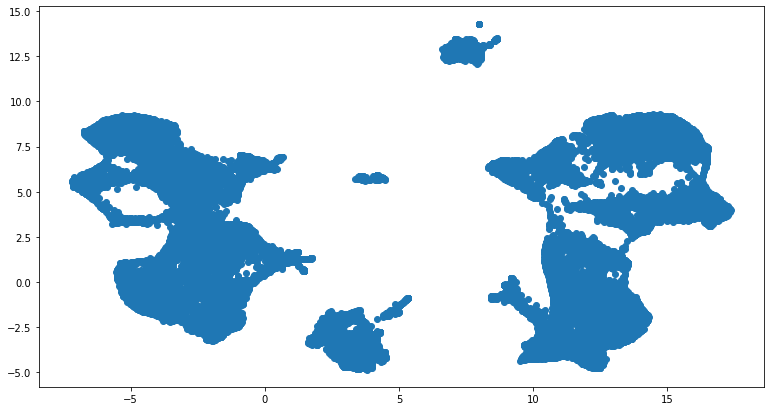

In [ ]:
#визуализируем в 2d то, что мы получили с помощью UMAP
plt.figure(figsize=(13, 7))
plt.subplot().scatter(um_data_2dim[:, 0], um_data_2dim[:, 1])
plt.show()

# **K-means clustering**

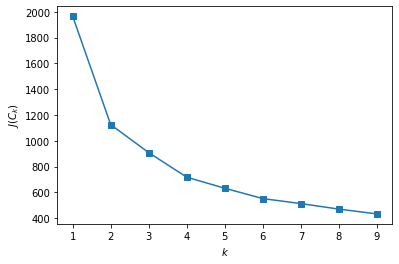

In [ ]:
#Ищем оптимальное количество кластеров для K-means и друих алгоритмов с помощью "метода локтя" 
#(https://habr.com/ru/company/jetinfosystems/blog/467745/  |   https://habr.com/ru/company/ods/blog/325654/)
from sklearn.cluster import KMeans

inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(um_data_2dim)
    inertia.append(np.sqrt(kmeans.inertia_))

#строим график, видим, что есть два изгиба -- 4/6, смотря на картинку UMAP понимаем, что 4 кластера -- мало
plt.plot(range(1, 10), inertia, marker='s')
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')
plt.show()

In [ ]:
#Ищем оптимальное количество кластеров для K-means и друих алгоритмов с помощью "метода силуэта"
#(https://habr.com/ru/company/jetinfosystems/blog/467745/)
from sklearn.metrics import silhouette_score
sil_coeffs = []
for n_cluster in range(2, 10):
  kmeans = KMeans(n_clusters=n_cluster).fit(um_data_2dim)
  label = kmeans.labels_ 
  sil_coeff = silhouette_score(um_data_2dim, label, metric='euclidean')
  sil_coeffs.append(sil_coeff)

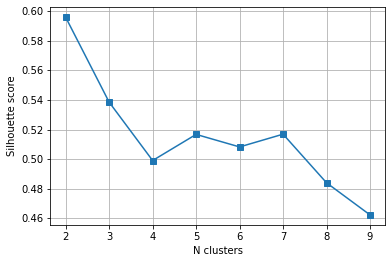

In [ ]:
#строим график, видим, что есть два пика -- 4/6, смотря на картинку UMAP понимаем, что 4 кластера -- мало
plt.plot(range(2, 10), sil_coeffs, marker='s')
plt.xlabel('N clusters')
plt.ylabel('Silhouette score')
plt.grid()
plt.show()

In [ ]:
#Кластеризуем с помошью K-means (кластеризация методом разбиений)
n_clusters = 7 #выбрали 6 кластеров
kmeans = KMeans(n_clusters=n_clusters, random_state=1).fit(um_data_2dim)
data['clusters_kmeans'] = kmeans.fit_predict(um_data_2dim)
print(data)

       latitude  longitude  ...  availability_365  clusters_kmeans
0      40.64749  -73.97237  ...               365                3
1      40.75362  -73.98377  ...               355                1
2      40.80902  -73.94190  ...               365                0
3      40.68514  -73.95976  ...               194                2
4      40.79851  -73.94399  ...                 0                1
...         ...        ...  ...               ...              ...
48890  40.67853  -73.94995  ...                 9                3
48891  40.70184  -73.93317  ...                36                3
48892  40.81475  -73.94867  ...                27                1
48893  40.75751  -73.99112  ...                 2                6
48894  40.76404  -73.98933  ...                23                4

[48895 rows x 8 columns]


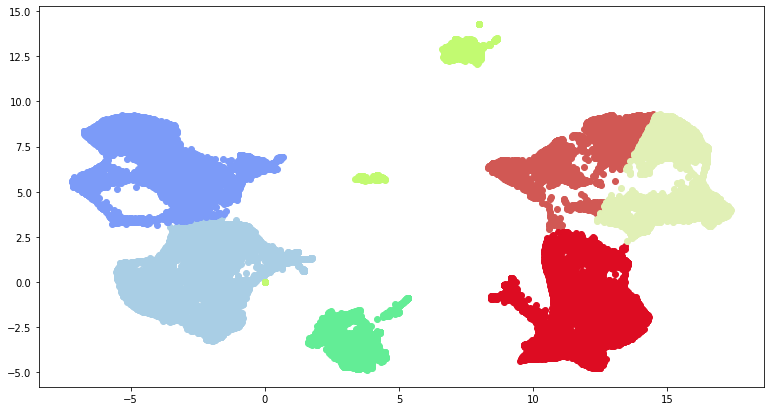

In [ ]:
#Визуализируем
def show_clusters(type_of_clust, n_clusters):
  clusters = np.array(data[type_of_clust]).reshape((len(data[type_of_clust]), 1))
  plot_data = np.append(um_data_2dim, clusters, 1)
  fig = plt.figure(figsize=(13, 7))
  ax = plt.subplot()
  for i in range(n_clusters):
    z = plot_data*((plot_data[:, 2] == i).reshape((len(data[type_of_clust]), 1)))
    ax.scatter(z[:, 0], z[:, 1], c = [[random.random(), random.random(), random.random()]])
  plt.show()

show_clusters('clusters_kmeans', n_clusters=7)

# **DBSCAN clustering** 


In [ ]:
#Кластеризуем с помощью DBSCAN, алгоритм не требует количества кластеров (Плотностная непараметрическая кластеризация) (https://ru.wikipedia.org/wiki/DBSCAN)
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(um_data_2dim) #параметры (eps, min_samples) выбираются, как и в большинстве таких случаев, на угад
data['clusters_dbscan'] = db.fit_predict(um_data_2dim)
print(data)
n_clusters = len(data['clusters_dbscan'].unique()) #смотрим сколько он нам кластеров выделил
print(n_clusters)

       latitude  longitude  ...  clusters_kmeans  clusters_dbscan
0      40.64749  -73.97237  ...                3                0
1      40.75362  -73.98377  ...                1                1
2      40.80902  -73.94190  ...                0                2
3      40.68514  -73.95976  ...                2                1
4      40.79851  -73.94399  ...                1                1
...         ...        ...  ...              ...              ...
48890  40.67853  -73.94995  ...                3                0
48891  40.70184  -73.93317  ...                3                0
48892  40.81475  -73.94867  ...                1                1
48893  40.75751  -73.99112  ...                6                4
48894  40.76404  -73.98933  ...                4                2

[48895 rows x 9 columns]
9


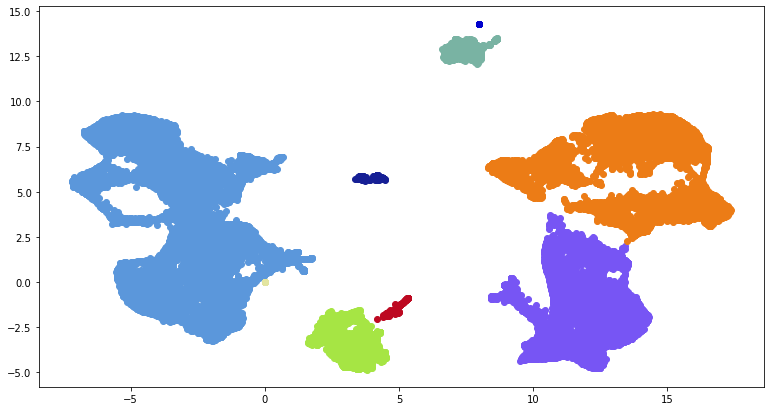

In [ ]:
#визуализируем с помощью функции, которую задали в K-means разделе (самый конец)
show_clusters('clusters_dbscan', n_clusters=n_clusters)

# **Birch clustering**

In [ ]:
n_clusters = 7
from sklearn.cluster import Birch #иерархическая кластеризация ('https://ru.wikipedia.org/wiki/BIRCH')
bi = Birch(n_clusters=n_clusters).fit(um_data_2dim)
data['clusters_birch'] = bi.fit_predict(um_data_2dim)
print(data)

       latitude  longitude  ...  clusters_dbscan  clusters_birch
0      40.64749  -73.97237  ...                0               2
1      40.75362  -73.98377  ...                1               1
2      40.80902  -73.94190  ...                2               0
3      40.68514  -73.95976  ...                1               1
4      40.79851  -73.94399  ...                1               3
...         ...        ...  ...              ...             ...
48890  40.67853  -73.94995  ...                0               2
48891  40.70184  -73.93317  ...                0               2
48892  40.81475  -73.94867  ...                1               3
48893  40.75751  -73.99112  ...                4               5
48894  40.76404  -73.98933  ...                2               0

[48895 rows x 10 columns]


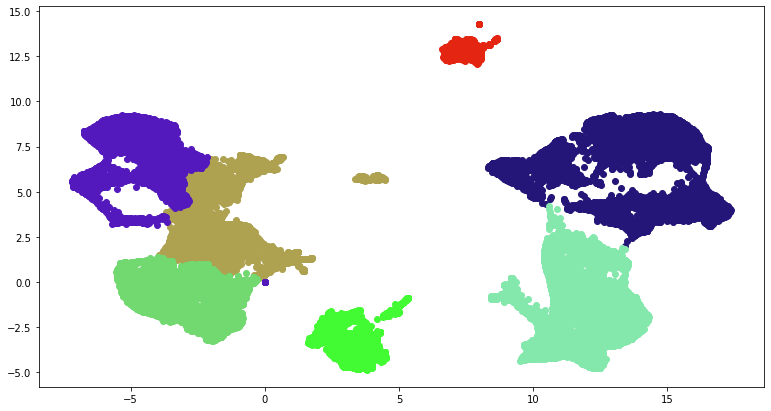

In [ ]:
#let's see what we got
show_clusters('clusters_birch', n_clusters=n_clusters)

# **Agglomerative Clustering**

In [ ]:
#AgglomerativeClustering (иерархическая агломеративная кластеризация)
n_clusters=6
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=n_clusters).fit(um_data_2dim)
data['clusters_agl'] = ac.fit_predict(um_data_2dim)
print(data)

       latitude  longitude  ...  clusters_dbscan  clusters_agl
0      40.64749  -73.97237  ...                0             2
1      40.75362  -73.98377  ...                1             1
2      40.80902  -73.94190  ...                2             3
3      40.68514  -73.95976  ...                3             0
4      40.79851  -73.94399  ...                1             1
...         ...        ...  ...              ...           ...
48890  40.67853  -73.94995  ...                0             2
48891  40.70184  -73.93317  ...                0             2
48892  40.81475  -73.94867  ...                1             1
48893  40.75751  -73.99112  ...                4             5
48894  40.76404  -73.98933  ...                2             3

[48895 rows x 8 columns]


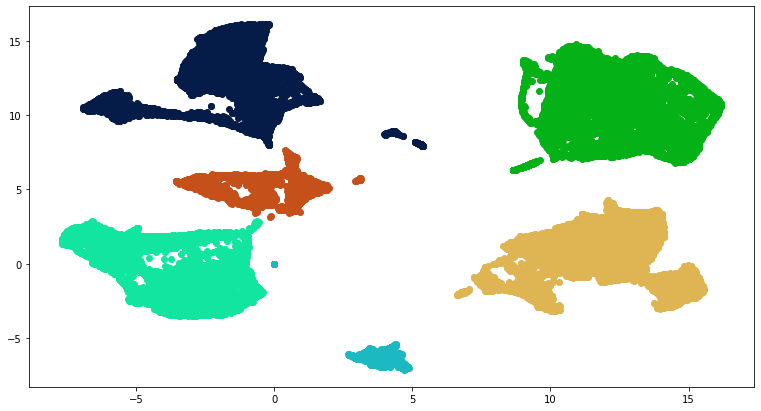

In [ ]:
#let's see what we got
show_clusters('clusters_agl', n_clusters=n_clusters)

# **Save the data and go to the maps**

In [ ]:
del data['reviews_per_month'] #удалим столбец, так как он нужен был только для кластеризации
data

,latitude,longitude,room_type,price,clusters_kmeans,clusters_dbscan,clusters_agl,clusters_birch
0,40.64749,-73.97237,1,149,3,0,2,3
1,40.75362,-73.98377,2,225,0,1,1,0
2,40.80902,-73.94190,1,150,4,2,3,2
3,40.68514,-73.95976,2,89,2,3,0,1
4,40.79851,-73.94399,2,80,0,1,1,0
...,...,...,...,...,...,...,...,...
48890,40.67853,-73.94995,1,70,3,0,2,3
48891,40.70184,-73.93317,1,40,3,0,2,3
48892,40.81475,-73.94867,2,115,0,1,1,0
48893,40.75751,-73.99112,0,55,5,4,5,4


In [ ]:
data.to_csv('gdrive/My Drive/NY_project/AB_NYC_2019_for_maps.csv', index=False, encoding='utf-8')